# Lecture 6
_____________


## _CAISO data_

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
plt.rcParams['figure.dpi'] = 600

In [4]:
df = pd.read_csv('data/CAISO-all-hourly.csv', index_col=0, parse_dates=True)
df.drop(['renewables'], axis=1, inplace=True) # because it's already added up
print(df)

                    geothermal biomass biogas small hydro  wind total  solar  \
2010-04-20 00:00:00     1056.0   323.0  170.0       250.0       632.0    0.0   
2010-04-20 01:00:00     1055.0   318.0  169.0       245.0       632.0    0.0   
2010-04-20 02:00:00     1058.0   316.0  168.0       240.0       677.0    0.0   
2010-04-20 03:00:00     1063.0   318.0  168.0       238.0       923.0    0.0   
2010-04-20 04:00:00     1066.0   318.0  168.0       247.0       875.0    0.0   
...                        ...     ...    ...         ...         ...    ...   
2021-11-30 19:00:00        889     264    207         237       272.0    0.0   
2021-11-30 20:00:00        887     262    204         205       426.0    3.0   
2021-11-30 21:00:00        885     263    204         187       444.0    2.0   
2021-11-30 22:00:00        884     259    205         168       748.0    2.0   
2021-11-30 23:00:00        885     255    205         145       964.0    3.0   

                     nuclear  thermal  

/var/folders/d0/8bmn6nx130n6ljv_75rbjbnh0000gn/T/ipykernel_56419/3361487900.py:1: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/CAISO-all-hourly.csv', index_col=0, parse_dates=True)


__Duck curve:__ compare hydro/solar hourly generation between summer 2011 to 2017

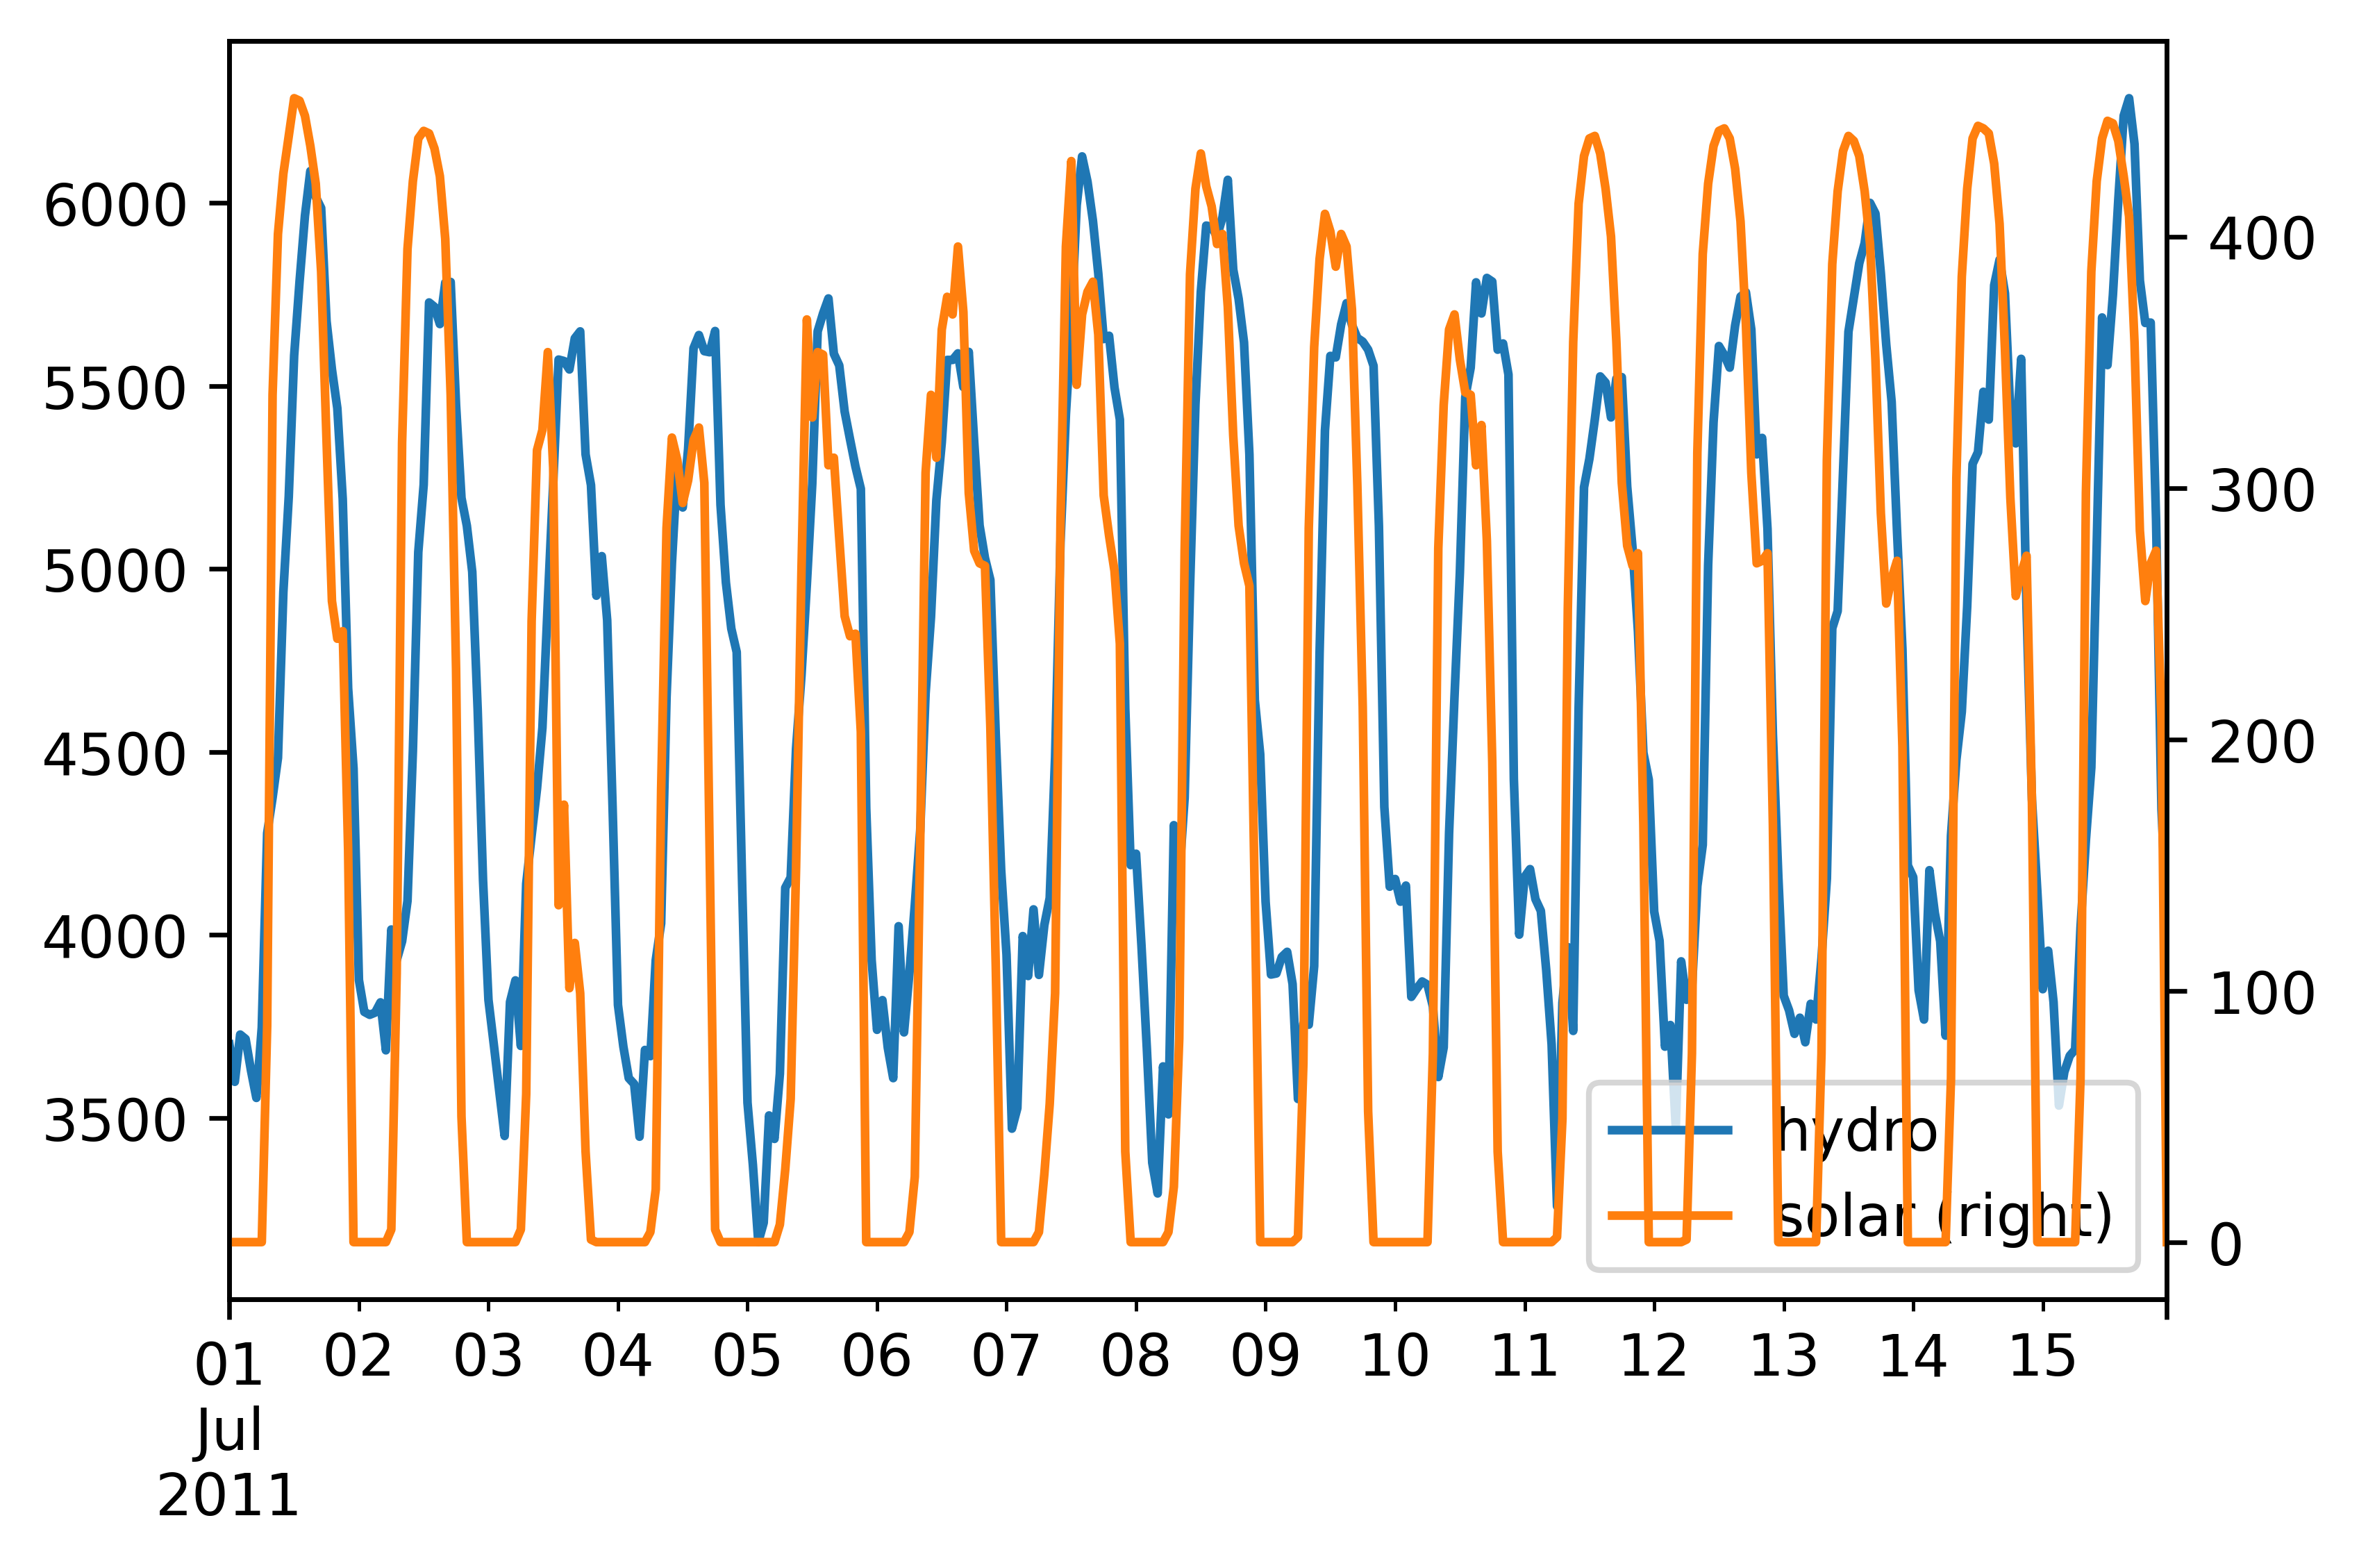

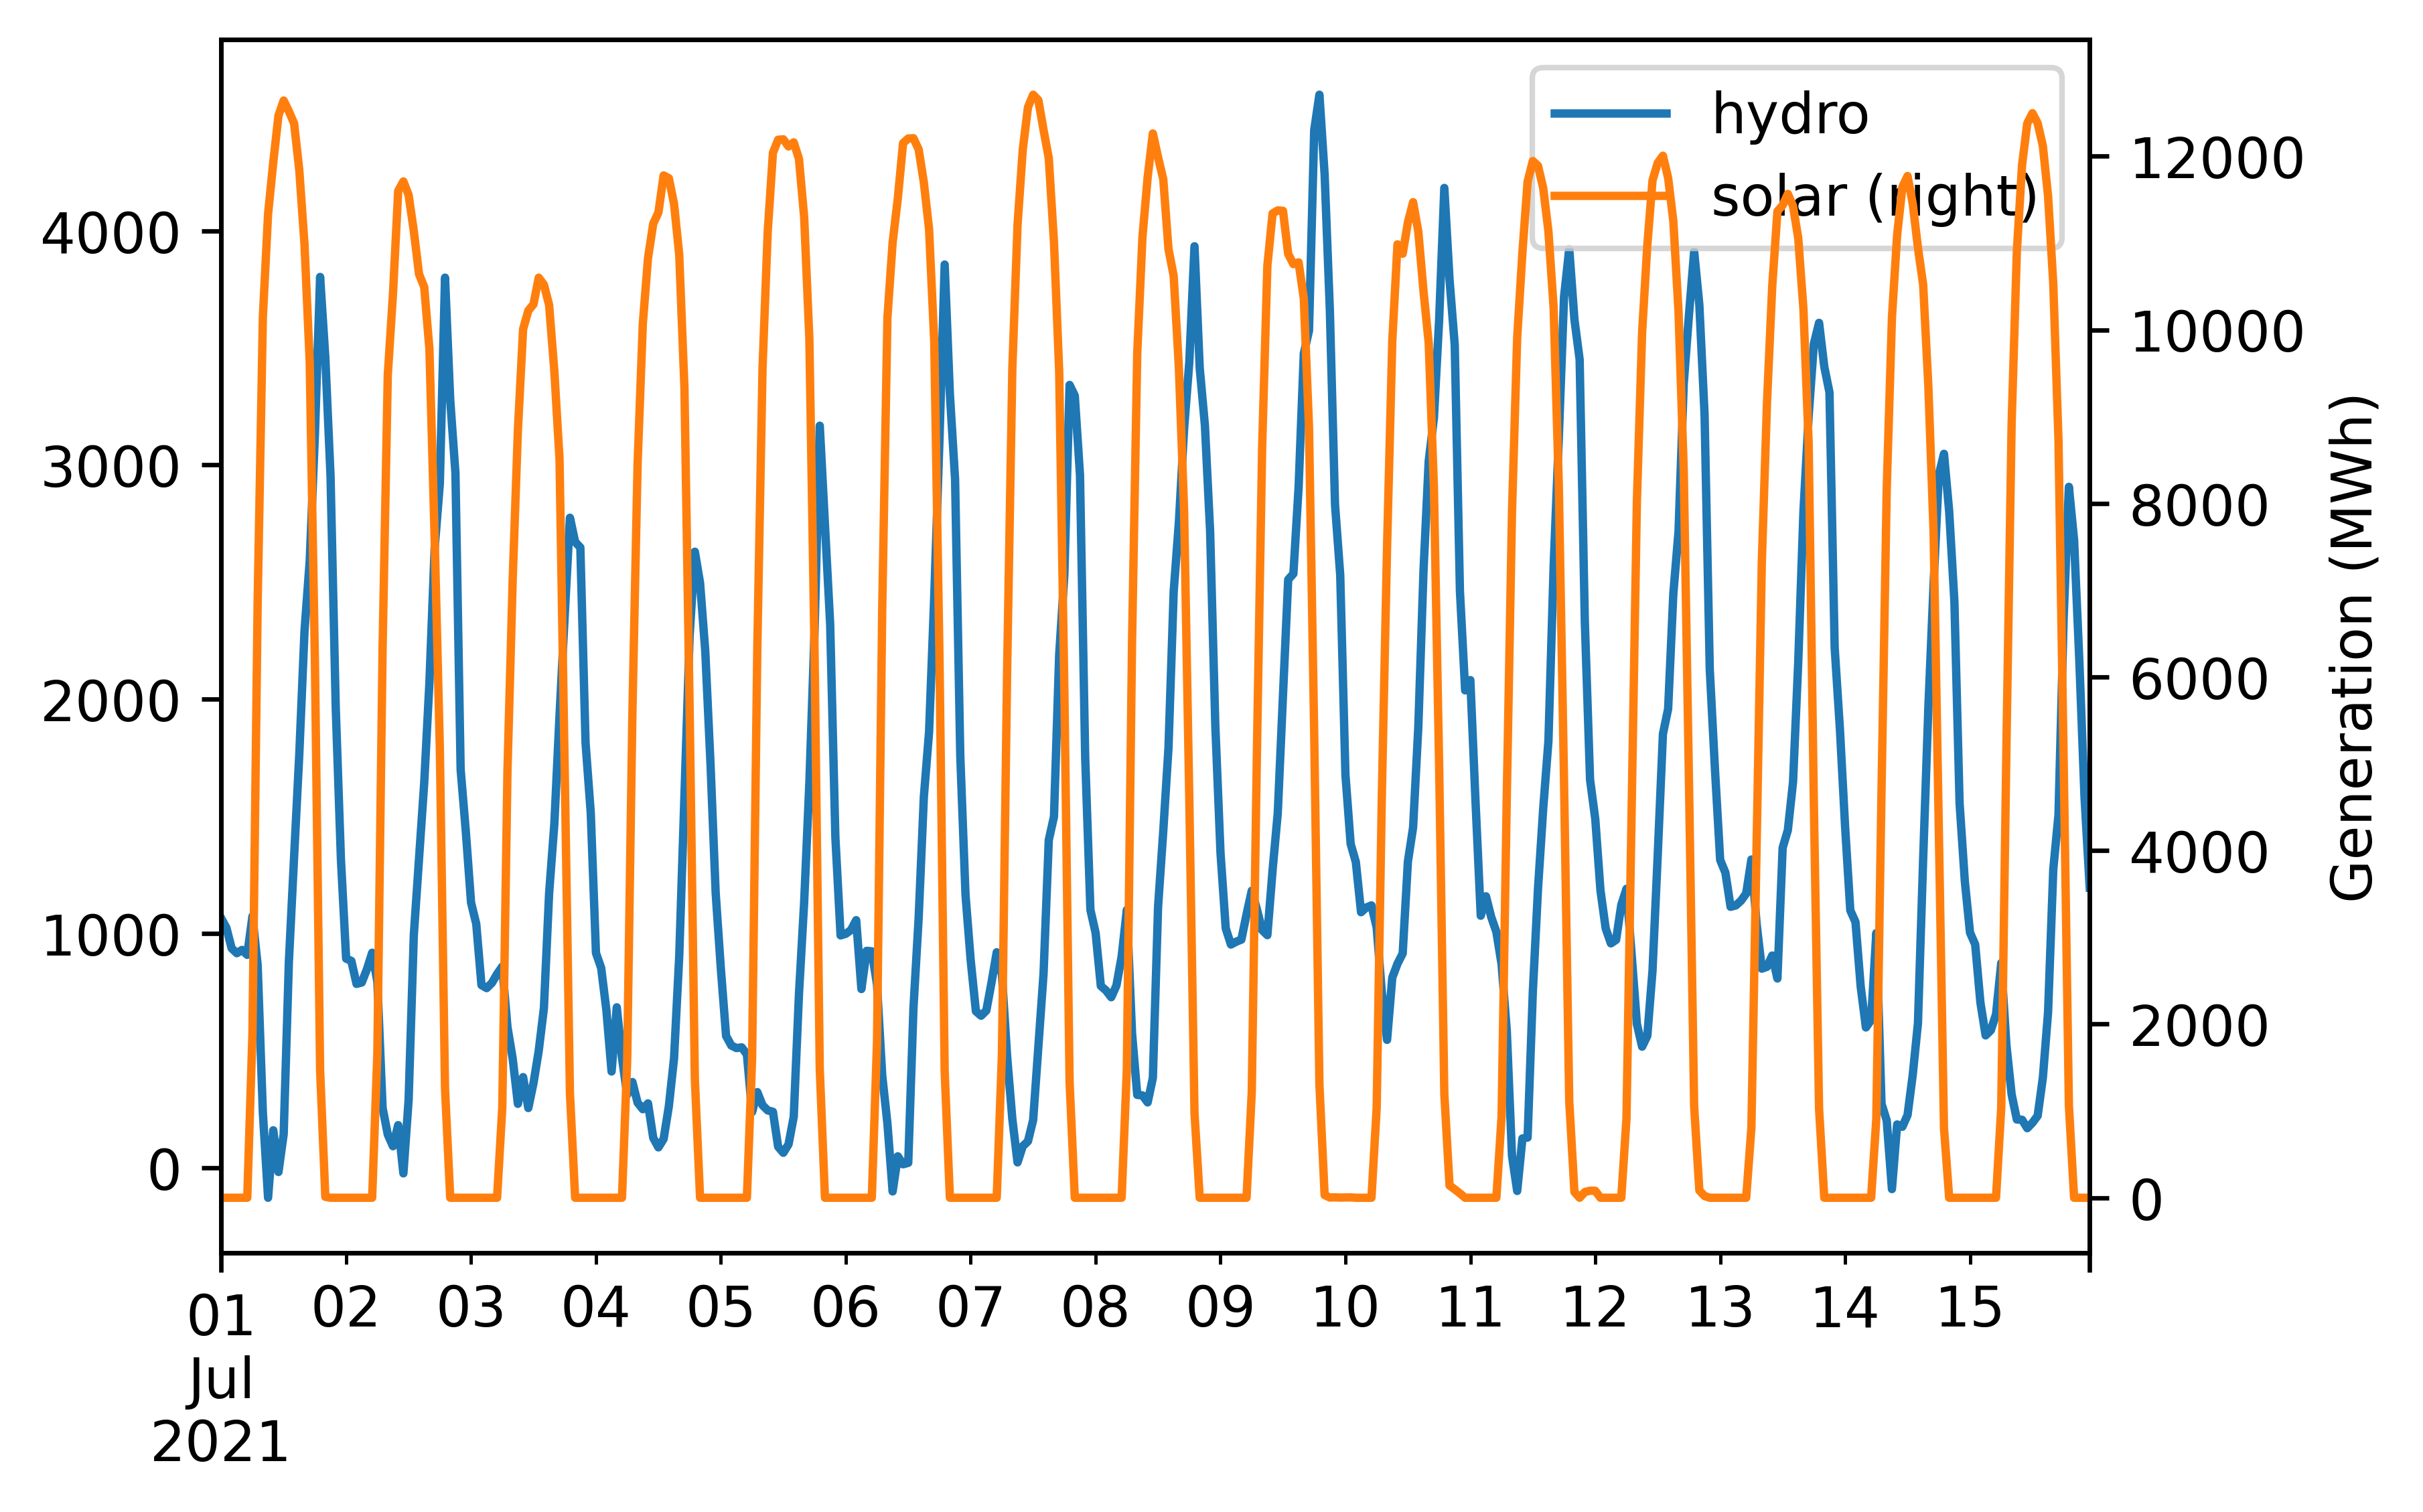

In [12]:
df[['hydro','solar']]['7/1/2011':'7/15/2011'].plot(secondary_y='solar')
df[['hydro','solar']]['7/1/2021':'7/15/2021'].plot(secondary_y='solar')
plt.ylabel('Generation (MWh)')
plt.show()

__Stacked area plot__

To plot the full dataset, upscale to monthly. Missing data from Jan 2018 - Jun 2018.

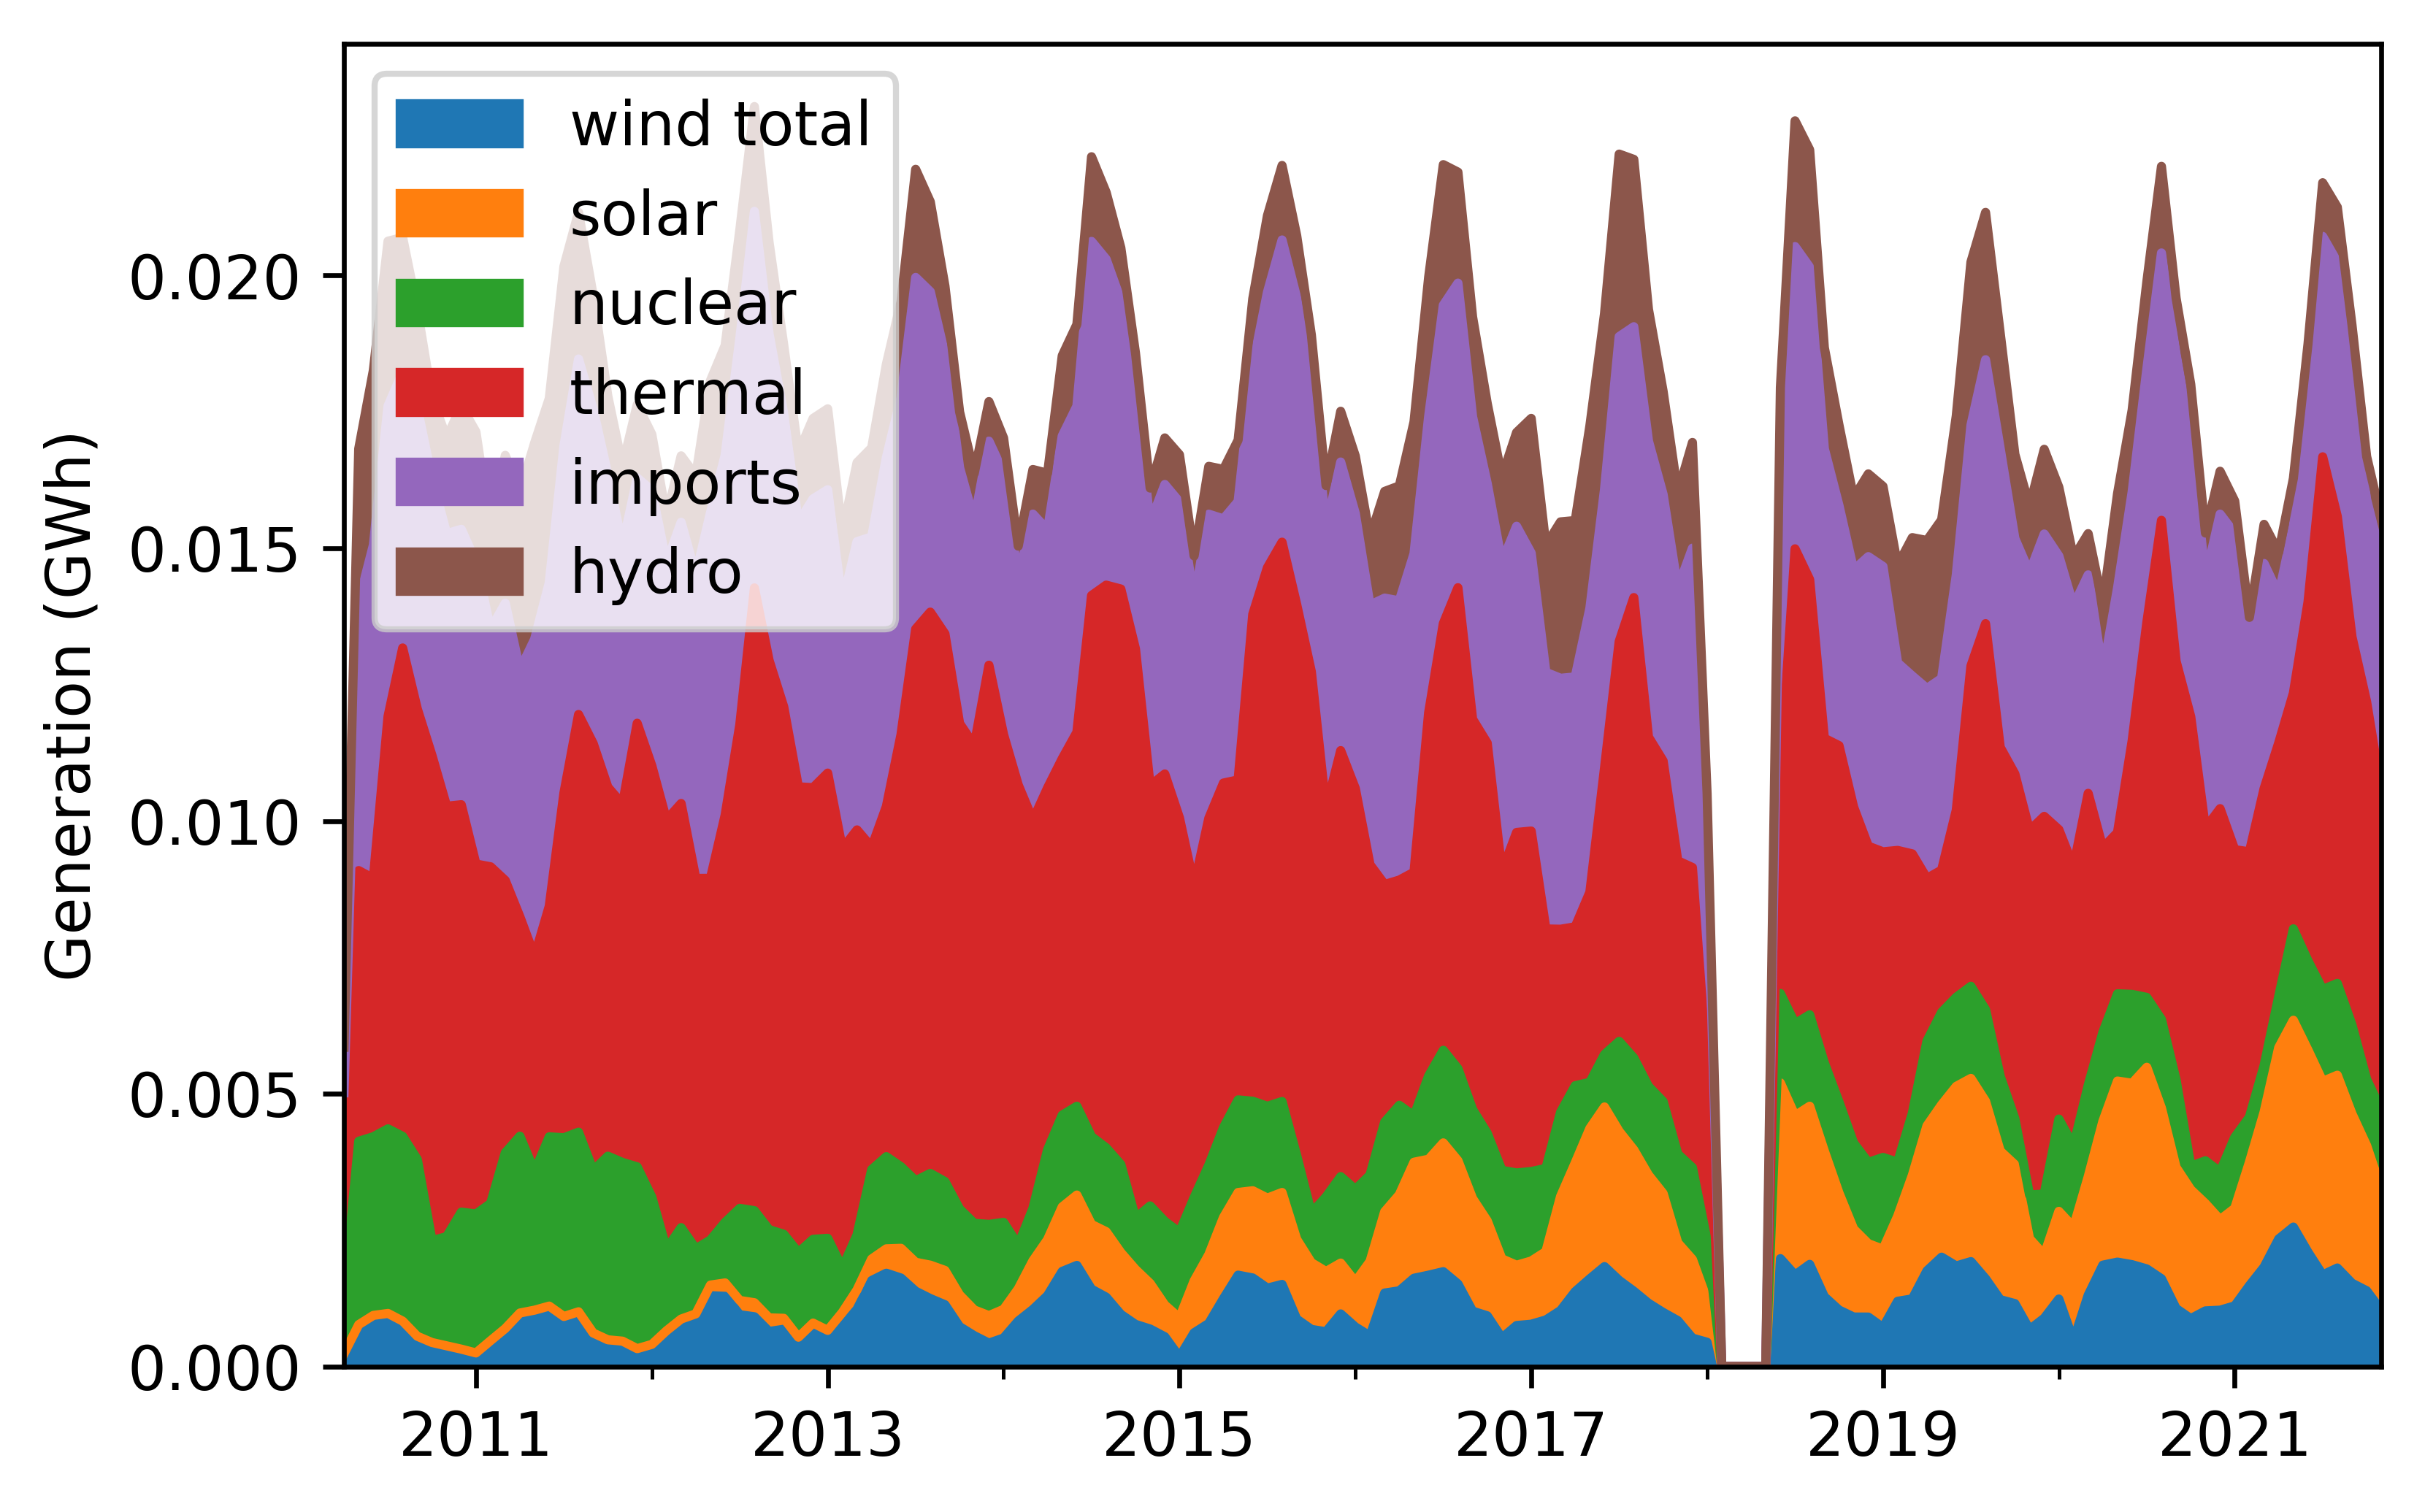

In [15]:
df = df.resample('M').sum() / 1000 # convert to GWh per month
df.plot.area()

plt.ylabel('Generation (GWh)')
plt.show()

----------

## _Folsom storage elevation_

Load data, grab only the storage and elevation columns; rename them

The column names in the original file are CDEC defaults

In [17]:
df = pd.read_csv('data/FOL.csv', index_col=0, parse_dates=True)
df = df[['FOL_STORAGE_AF', 'FOL_RES ELE_FEET']]
df.rename(columns={'FOL_STORAGE_AF': 'storage', 'FOL_RES ELE_FEET': 'elevation'}, inplace=True)

Text(0, 0.5, 'Water Surface Elevation (ft)')

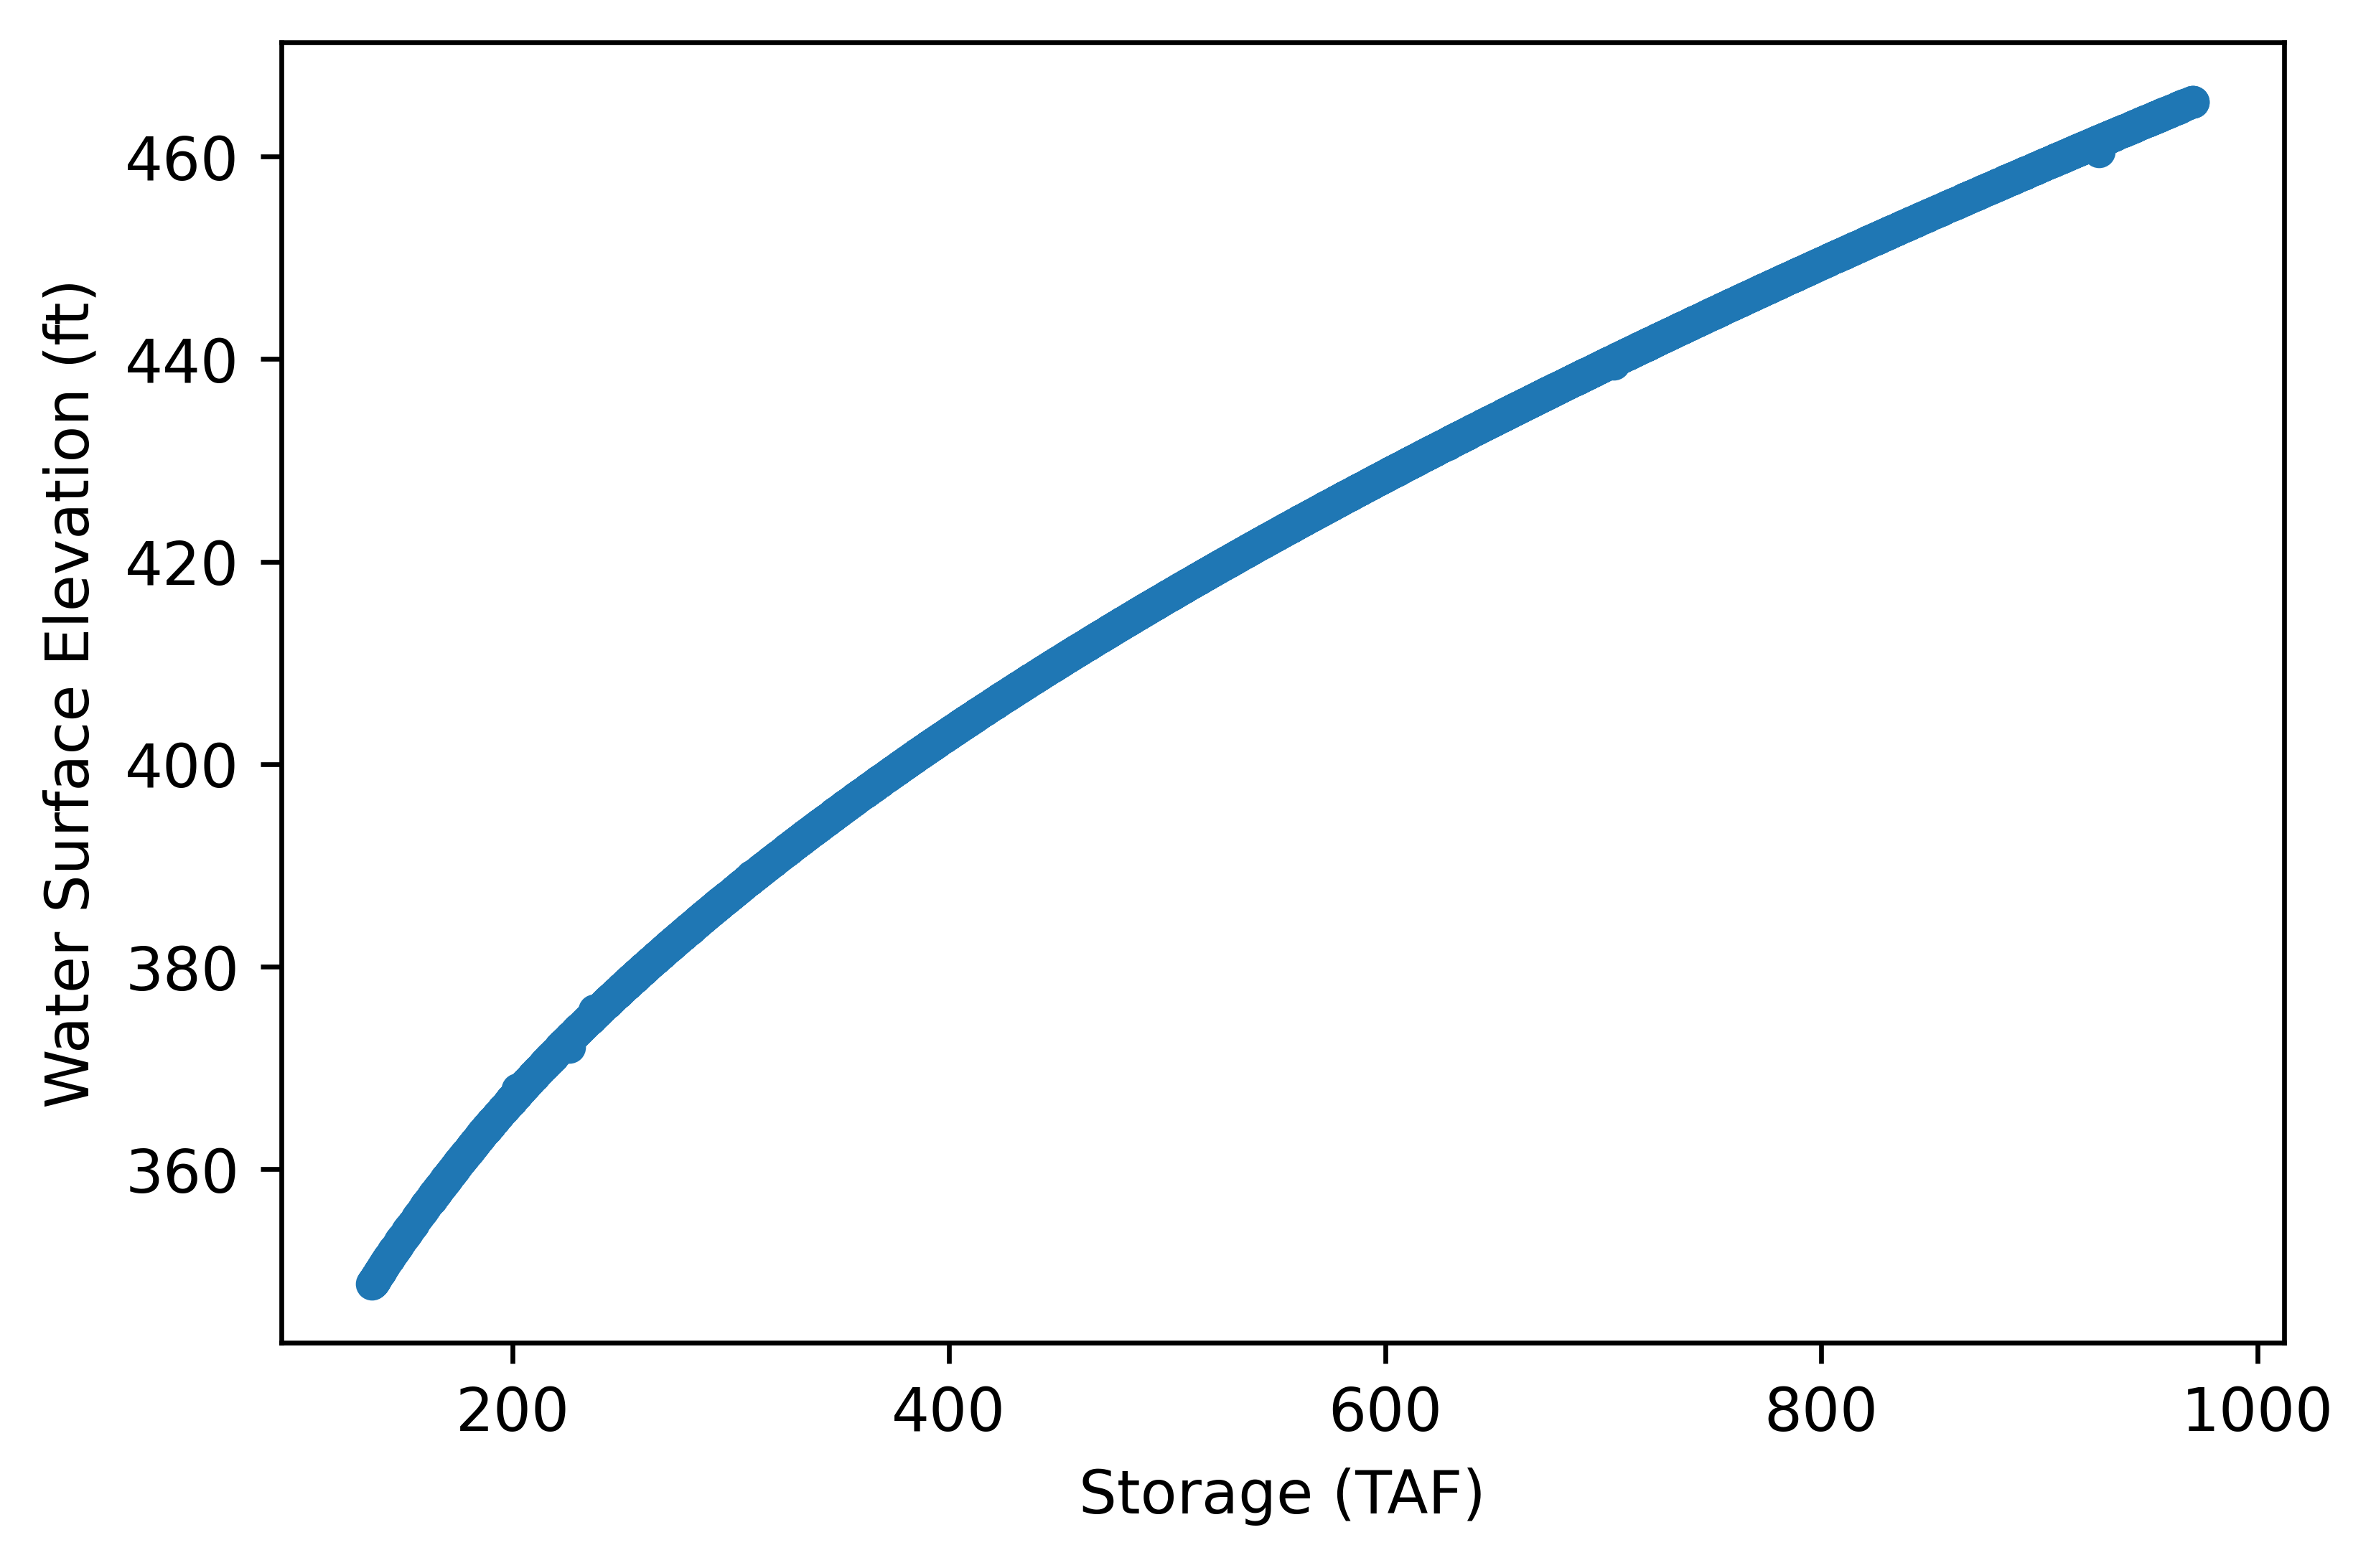

In [18]:
df.storage /= 1000 # AF to TAF
df.plot.scatter('storage', 'elevation')
plt.xlabel('Storage (TAF)')
plt.ylabel('Water Surface Elevation (ft)')

Then fit a quadratic and keep the equation for the next code example

In [20]:
p = np.polyfit(df.storage.values, df.elevation.values, 2) 
# polyfit returns the coefficients of the polynomial
print('Regression: Elevation = %f S**2 + %f S + %f' % tuple(p))
f = np.poly1d(p) # returns the polynomial function f

Regression: Elevation = -0.000076 S**2 + 0.212053 S + 329.325875


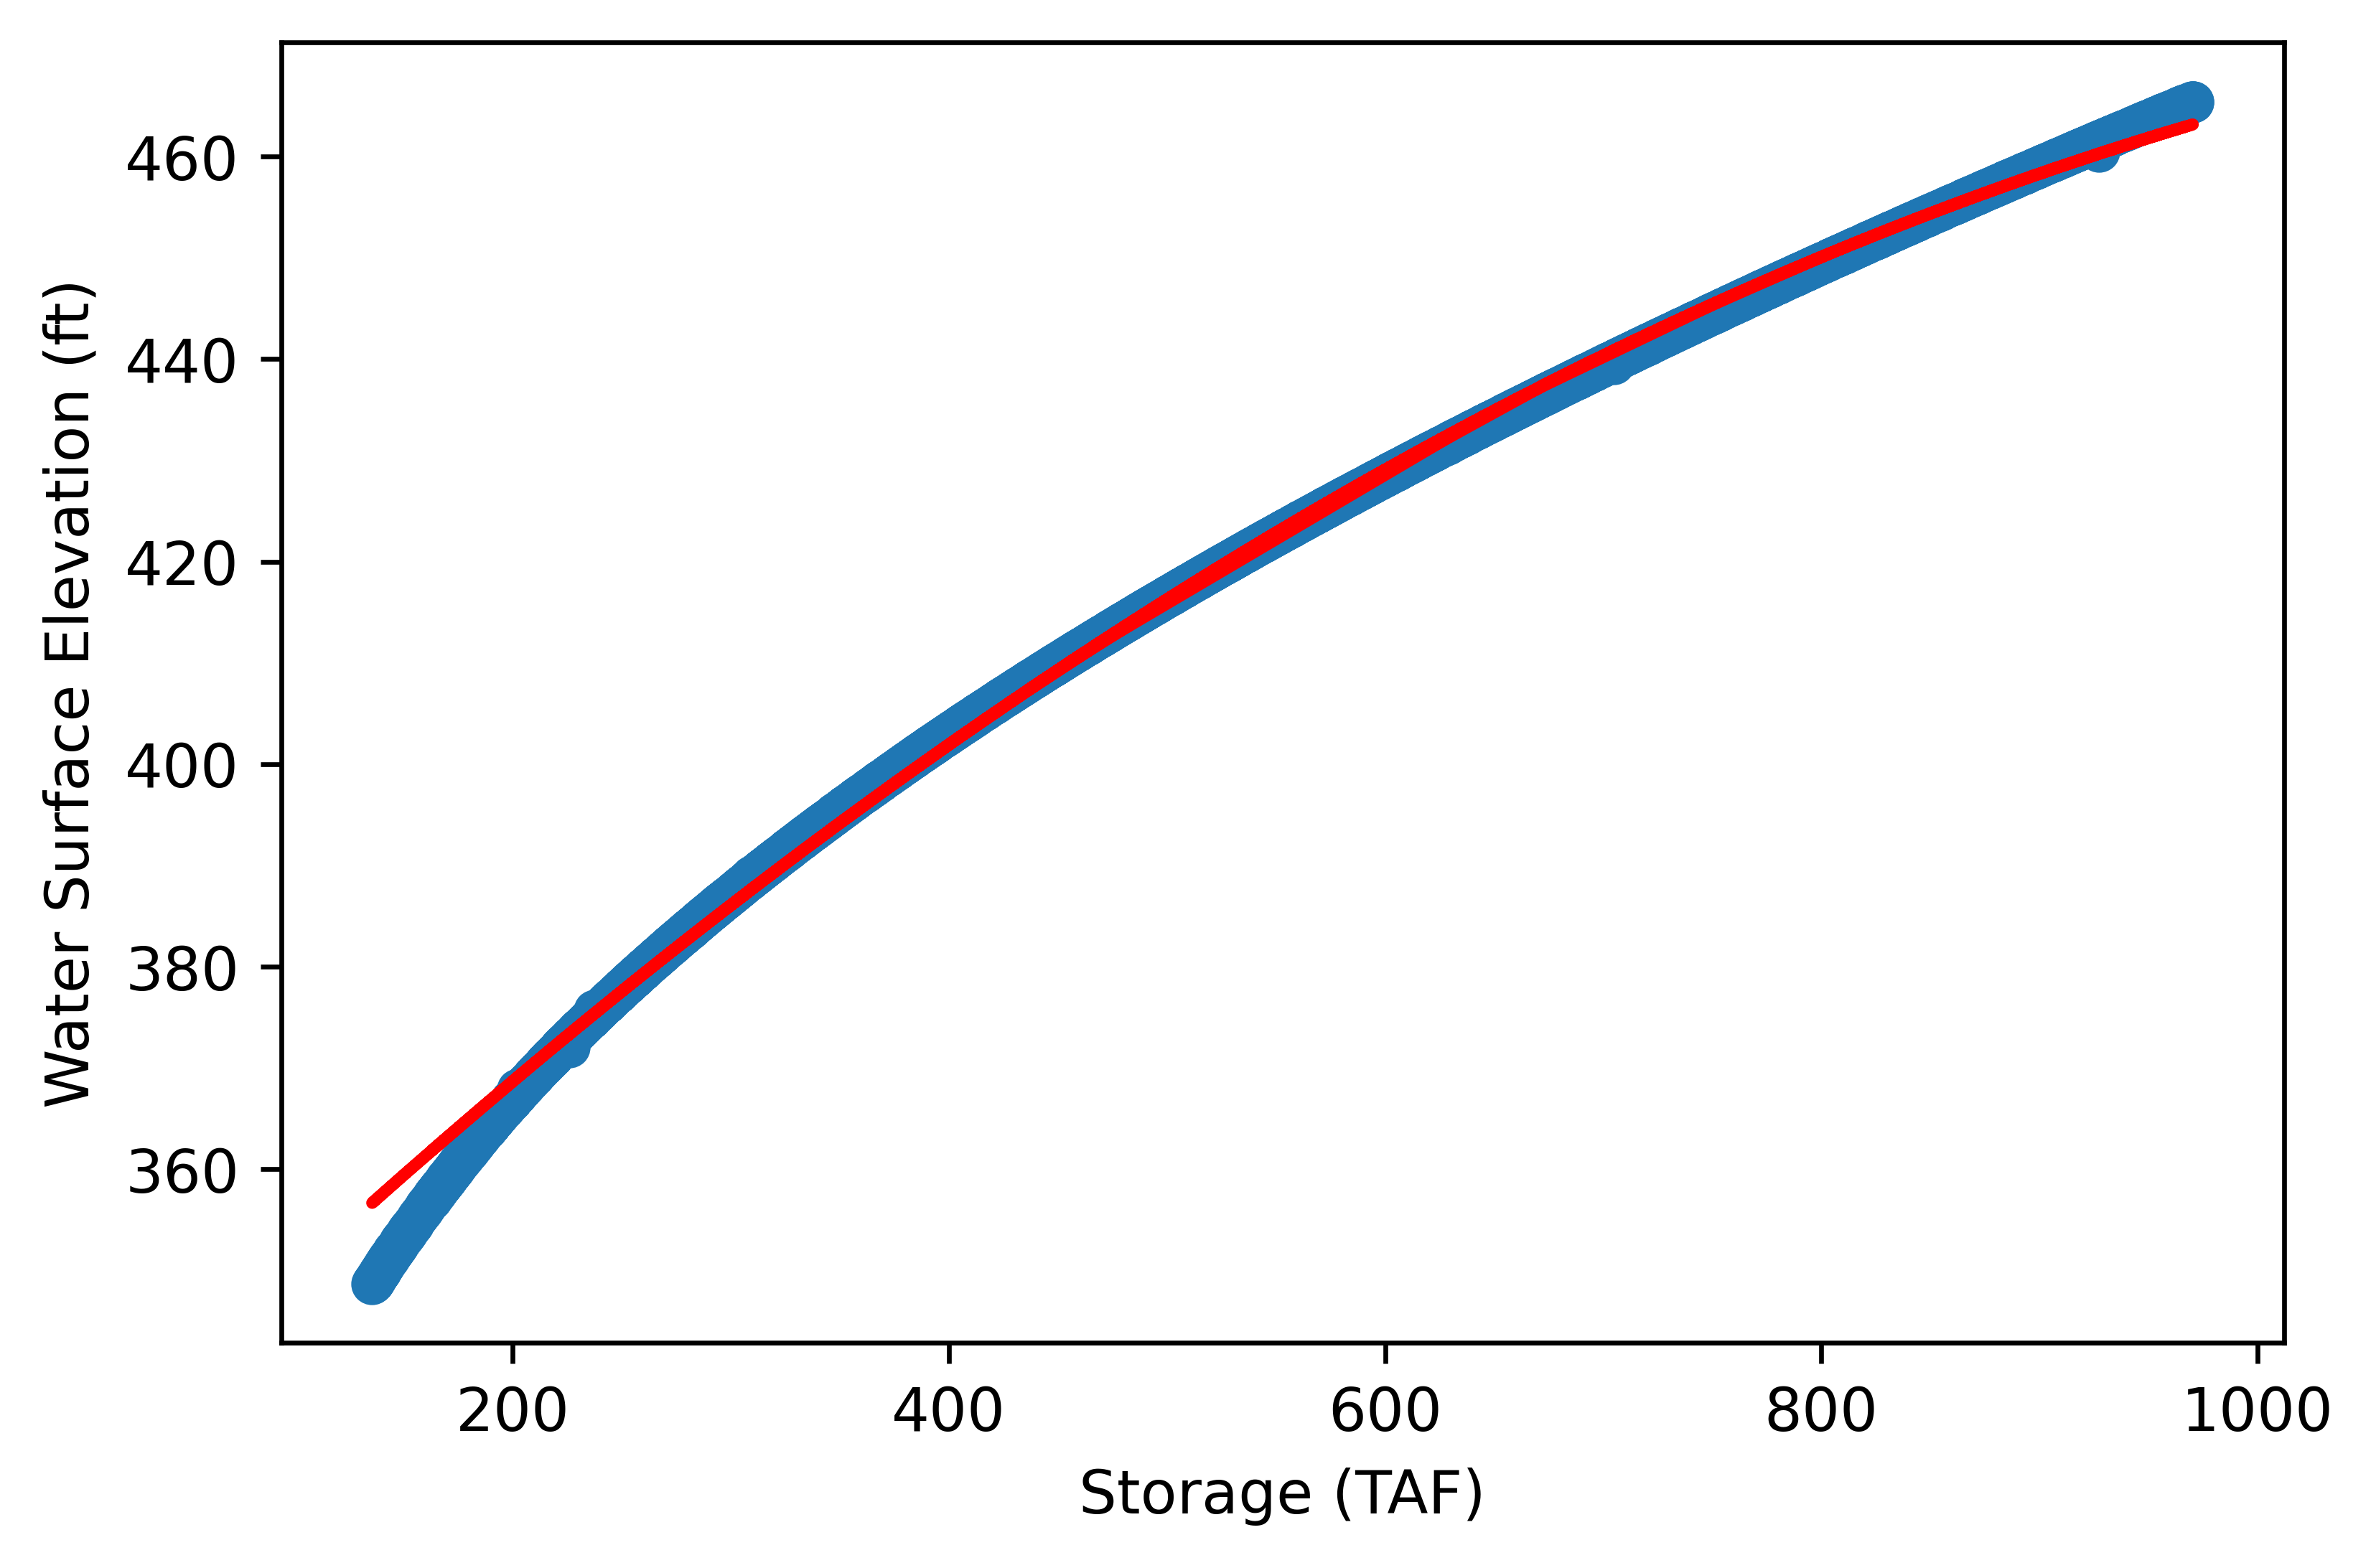

In [21]:
plt.scatter(df.storage.values, df.elevation.values)

plt.plot(df.storage.values, f(df.storage.values), color='r', linewidth=2) # plot fitted function on top of storage points
plt.xlabel('Storage (TAF)')
plt.ylabel('Water Surface Elevation (ft)')
plt.show()

--------------

## _Hydropower model_

In [22]:
cfs_to_tafd = 2.29568411*10**-5 * 86400 / 1000

In [23]:
def storage_to_elevation(S): # from regression above
  return -0.000078*S**2 + 0.213526*S + 328.922121

Some parameters assumed specific to Folsom

In [24]:
def simulate_folsom(Q):
    K = 975 # TAF capacity
    D = 3.5 # TAF/day water demand
    # assume a constant downstream water elevation
    # (neglects the hydraulic effects of changing flow rate)
    downstream_wse = 134 # feet
    turbine_max_outflow = 8600 # cfs
    efficiency = 0.82 # 85-90% is a good efficiency for turbine; this 82% is outdated
    
    T = len(Q)
    S = np.zeros(T) # storage, TAF
    WSE = np.zeros(T) # water surface elevation, ft
    R = np.zeros(T) # release (for demand), TAF/d
    spill = np.zeros(T) # additional release for spill, TAF/d
    
    S[0] = K # start simulation full
    WSE[0] = storage_to_elevation(S[0])
    R[0] = D
    
    for t in range(1,T):
        spill[t-1] = max(S[t-1] + Q[t-1] - R[t-1] - K, 0)
        S[t] = S[t-1] + Q[t-1] - R[t-1] - spill[t-1]
        WSE[t] = storage_to_elevation(S[t])

        if S[t] + Q[t] > D:
            R[t] = D
        else:
            R[t] = S[t] + Q[t]
   
    # hydropower calculations
    h = WSE - downstream_wse # hydraulic head array, feet
    # clip outflow values between 0 and turbine capacity
    turbine_outflow = np.clip((R+spill)/cfs_to_tafd, 0, turbine_max_outflow) 
    power = efficiency * h * turbine_outflow / (1.181*10**4) # units of MW
    
    return S, R+spill, power # storage, total release and power

In [25]:
df = pd.read_csv('data/FOL.csv', index_col=0, parse_dates=True)
Q = df.FOL_INFLOW_CFS.values * cfs_to_tafd # .values gives a numpy array

In [26]:
S, R, power = simulate_folsom(Q)

Add these results back into the original dataframe to plot with dates

In [29]:
df['S_sim'] = pd.Series(S, index=df.index)
df['R_sim'] = pd.Series(R, index=df.index)
df['power_sim'] = pd.Series(power, index=df.index)

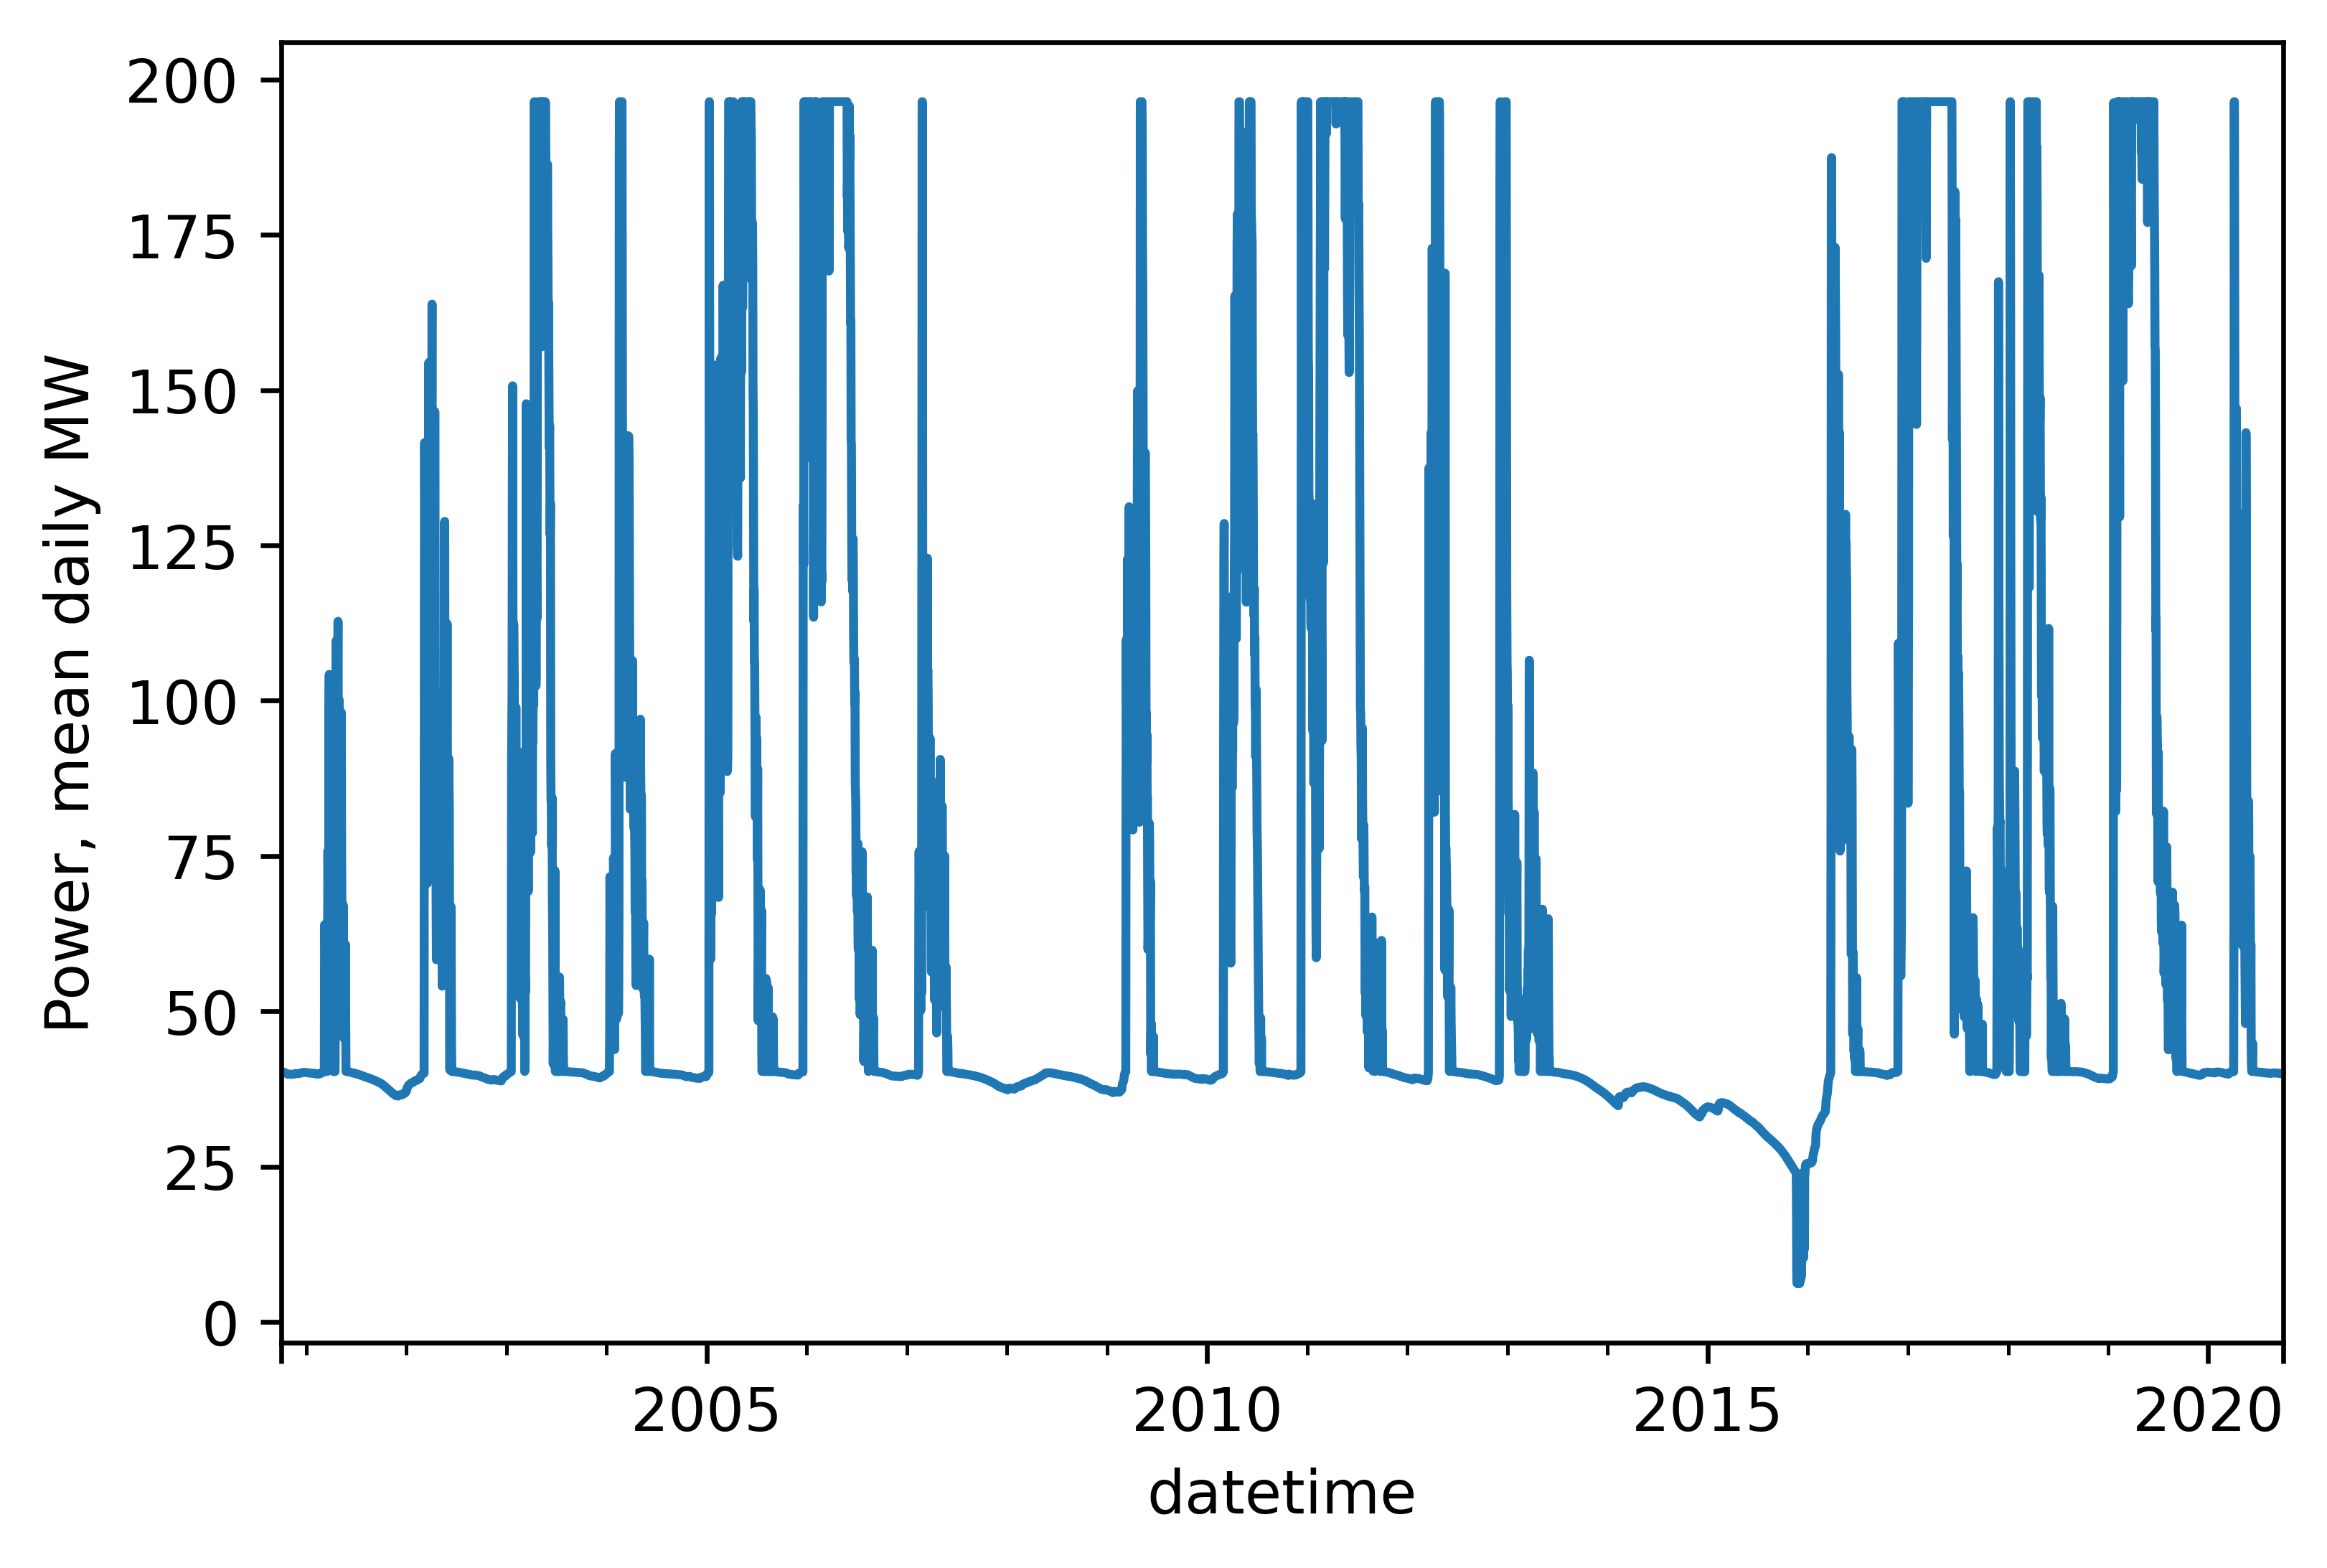

In [30]:
df.power_sim.plot()
plt.ylabel('Power, mean daily MW')
plt.show()

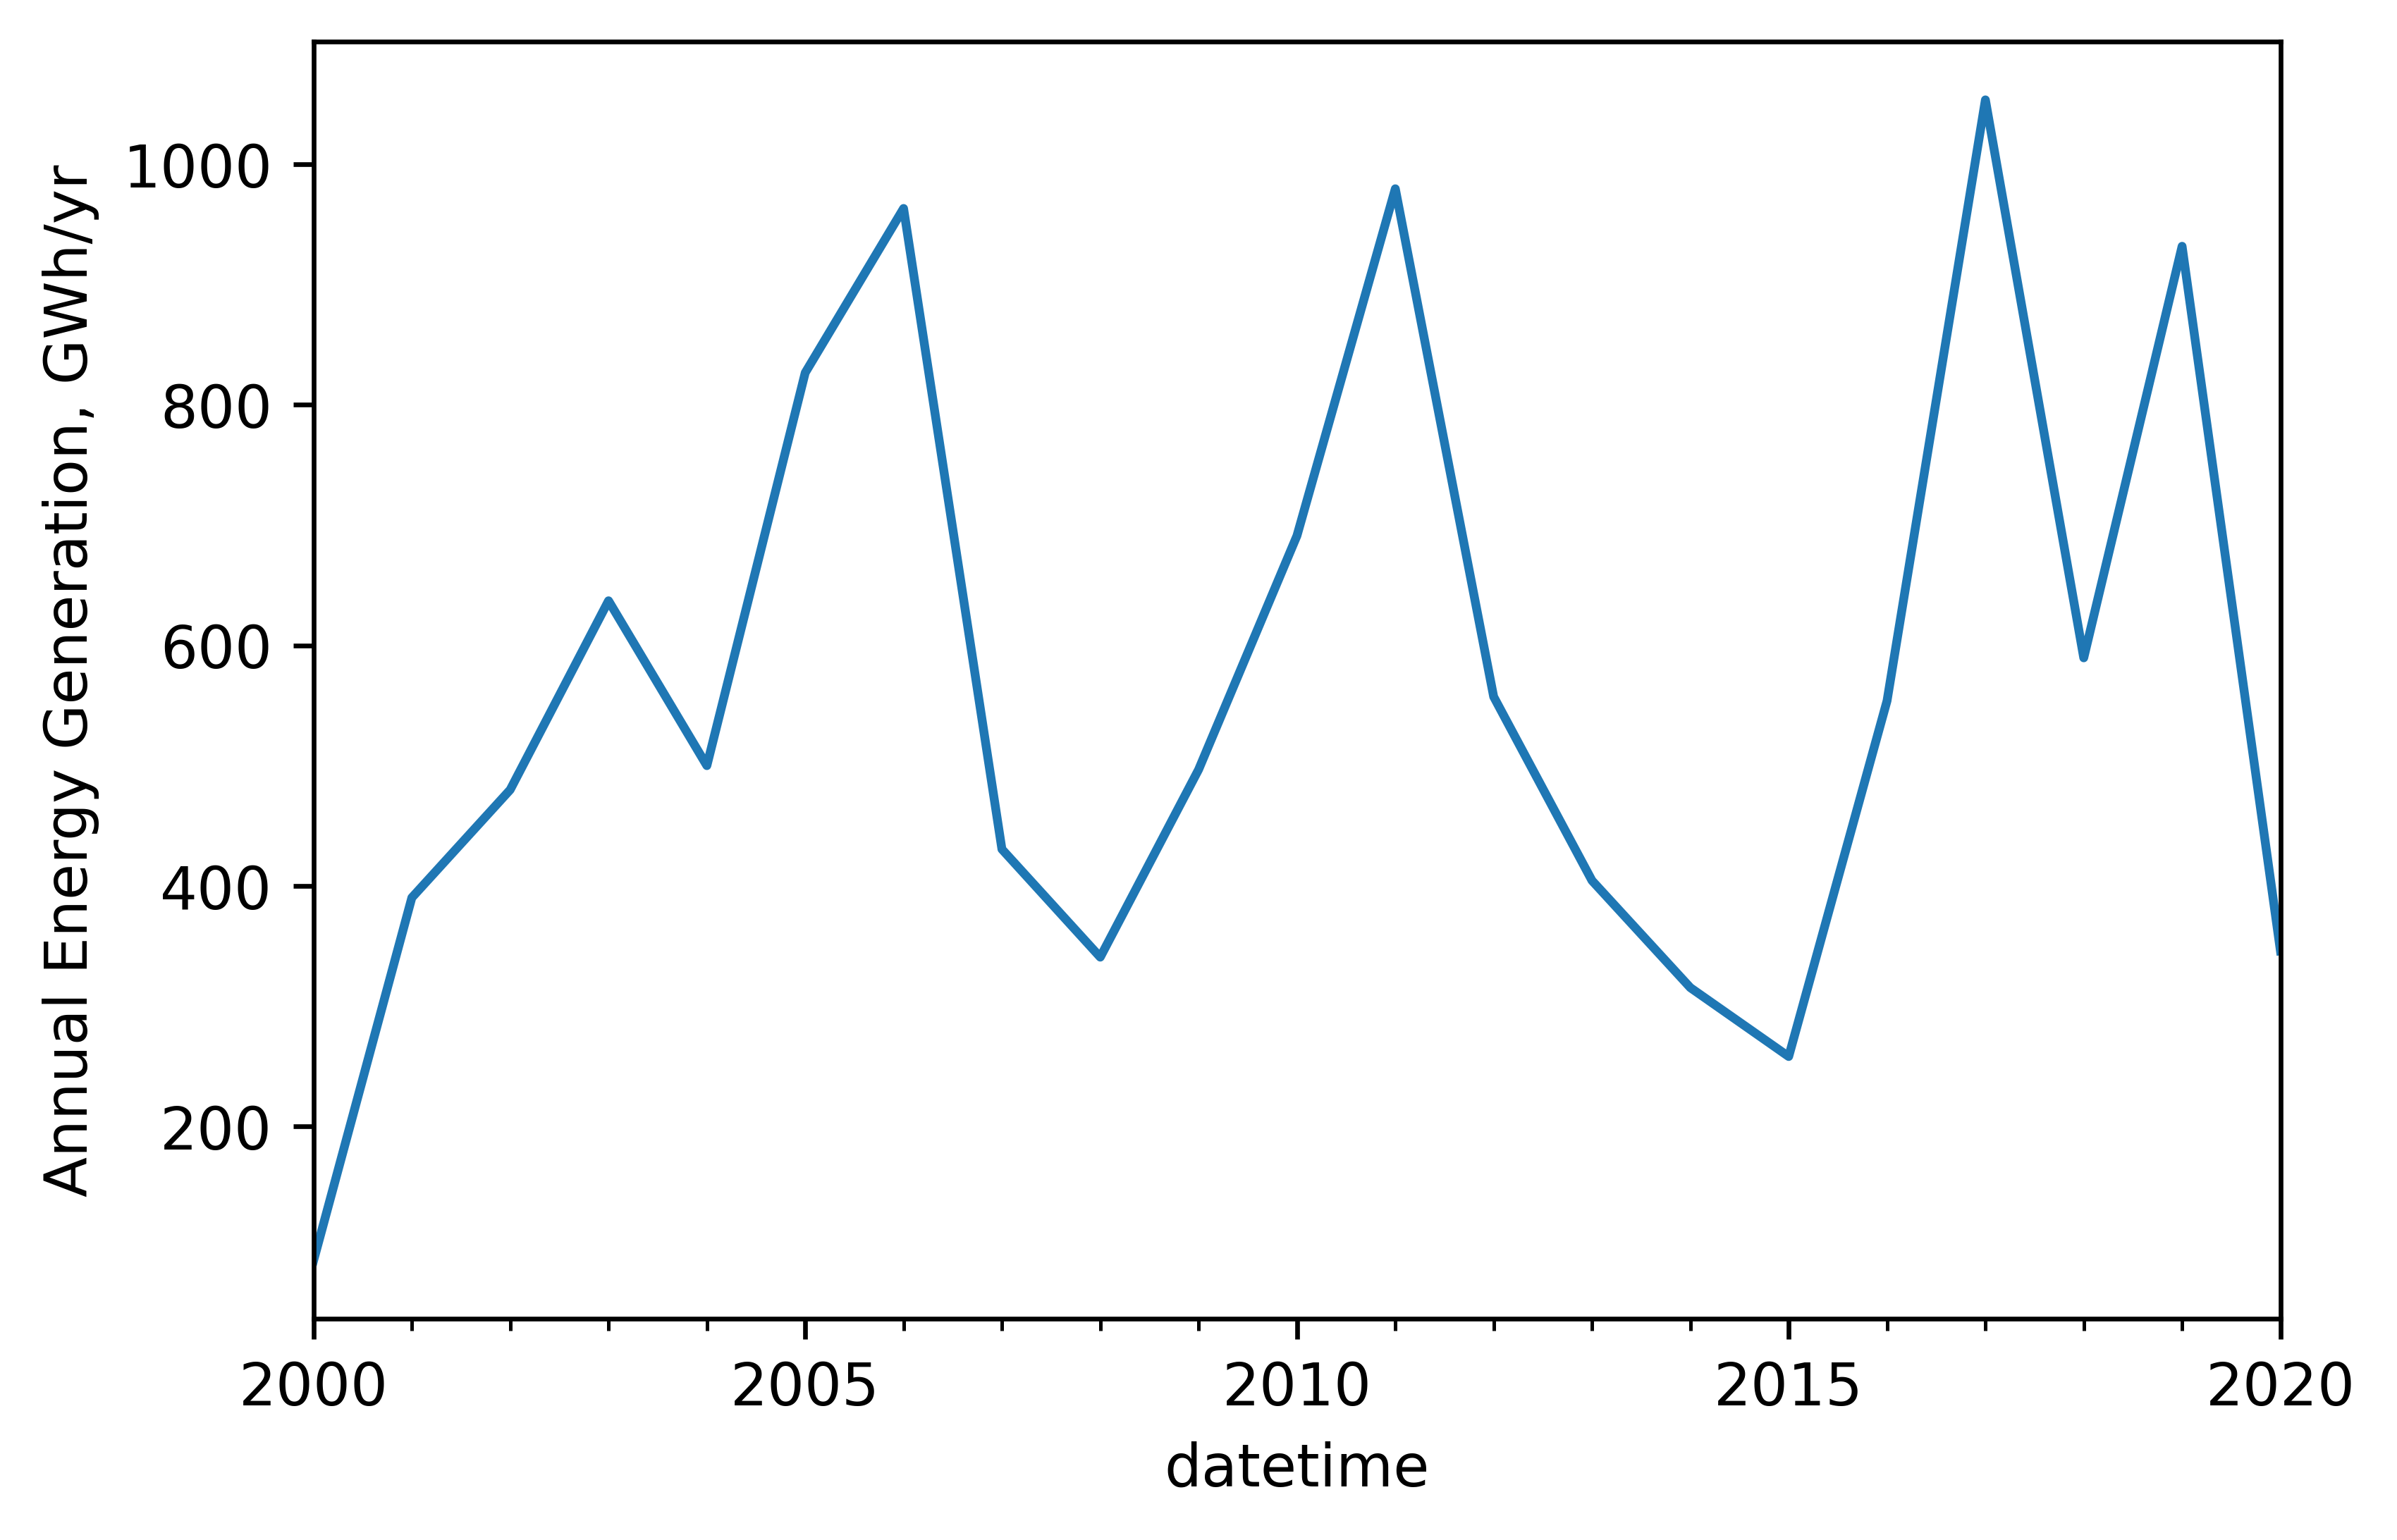

In [31]:
(24/1000*df.power_sim.resample('A').sum()).plot() # convert to GWh/year
plt.ylabel('Annual Energy Generation, GWh/yr')
plt.show()

-------